In [1]:
#importar librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('comment_analized.csv')
df.head()

,Text,Toxic,Abusive,Threat,Provocative,Obscene,Hatespeech,Racist,Nationalist,Sexist,Homophobic,ReligiousHate,Radicalism,Sentiment
0,only people would just take step back make thi...,False,False,False,False,False,False,False,False,False,False,False,False,Negative
1,enforcement trained shoot apprehend they train...,True,True,False,False,False,False,False,False,False,False,False,False,Negative
2,dont reckon them black lives matter banners be...,True,True,False,False,True,False,False,False,False,False,False,False,Negative
3,there very large number people like police off...,False,False,False,False,False,False,False,False,False,False,False,False,Negative
4,arab dude absolutely right should have been sh...,False,False,False,False,False,False,False,False,False,False,False,False,Negative


In [3]:
df['Text'][3]

'there very large number people like police officers they called criminals reason have police officers fact that criminals like police officers testament good work that police officers protecting public when children family danger hessitate call help call police about time people stopped complaining started give police some respect hard work dedication that often requires them their lives line serve public'

In [4]:
df['Sentiment'][3]

'Negative'

In [5]:
!pip install nltk -q

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    if isinstance(text, str):
    # Convertir a minúsculas
        text = text.lower()

        # Eliminar URLs y caracteres especiales
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\@w+|\#', '', text)
        text = re.sub(r'[^A-Za-z\s]', '', text)

        # Tokenizar y lematizar
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))

        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        # Reconstruir el texto
        return ' '.join(tokens)
    else:
          return ''  # Devolver una cadena vacía si el valor no es una cadena

# Aplicar preprocesamiento al dataset
df['Cleaned_Text'] = df['Text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
df.head()

,Text,Toxic,Abusive,Threat,Provocative,Obscene,Hatespeech,Racist,Nationalist,Sexist,Homophobic,ReligiousHate,Radicalism,Sentiment,Cleaned_Text
0,only people would just take step back make thi...,False,False,False,False,False,False,False,False,False,False,False,False,Negative,people would take step back make case wasnt an...
1,enforcement trained shoot apprehend they train...,True,True,False,False,False,False,False,False,False,False,False,False,Negative,enforcement trained shoot apprehend trained sh...
2,dont reckon them black lives matter banners be...,True,True,False,False,True,False,False,False,False,False,False,False,Negative,dont reckon black life matter banner held whit...
3,there very large number people like police off...,False,False,False,False,False,False,False,False,False,False,False,False,Negative,large number people like police officer called...
4,arab dude absolutely right should have been sh...,False,False,False,False,False,False,False,False,False,False,False,False,Negative,arab dude absolutely right shot extra time sho...


In [8]:
df['Cleaned_Text'][3]

'large number people like police officer called criminal reason police officer fact criminal like police officer testament good work police officer protecting public child family danger hessitate call help call police time people stopped complaining started give police respect hard work dedication often requires life line serve public'

In [9]:
# 1. Definir las características (X) y las etiquetas (y)
#Vectorización con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(df['Cleaned_Text'])
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificar las dimensiones de los datos
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (800, 5000), X_test shape: (200, 5000)
y_train shape: (800,), y_test shape: (200,)


In [10]:
# Balancear las clases usando SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [11]:
#3. Definir el modelo SVM
svm = SVC()

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10,100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None]
}


In [12]:
# 4.Realizar búsqueda en la cuadrícula con validación cruzada
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='f1_macro', verbose=2)

In [13]:
#5. Obtener el mejor modelo
best_svm_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [14]:
# 5.Predecir en el conjunto de prueba
y_pred = best_svm_model.predict(X_test)

# Evaluación del modelo
# Imprimir las métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.805
Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.96      0.88       156
    Positive       0.63      0.27      0.38        44

    accuracy                           0.81       200
   macro avg       0.73      0.61      0.63       200
weighted avg       0.78      0.81      0.77       200



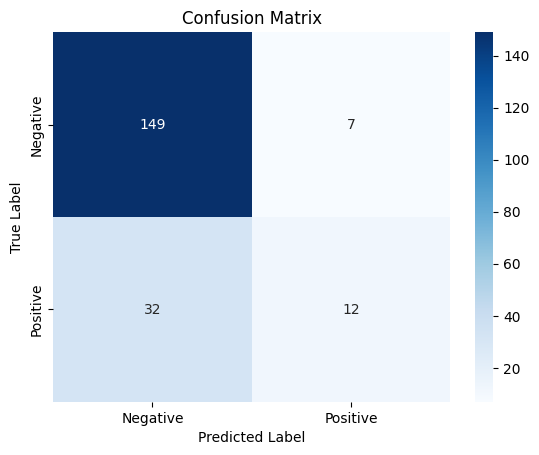

In [15]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Data Augmentation para aumentar la cantidad de datos de la clase minoritaria ·Positive· o No odio

In [17]:
!pip install nlpaug nltk -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 22.8 MB/s eta 0:00:00


In [19]:
import nltk
# Download the required resource - the english version is required
nltk.download('averaged_perceptron_tagger_eng')
import nlpaug.augmenter.word as naw
import random
import pandas as pd

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [23]:


# Aumentador de sinónimos
synonym_aug = naw.SynonymAug(aug_src='wordnet')

# Aumentador por inserción aleatoria
insert_aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")


# Seleccionar solo la clase minoritaria para aumentar
minority_class = df[df['Sentiment'] == 'Positive']

def augment_text(text, augmenter, n_augmentations=3):
    augmented_texts = []
    for _ in range(n_augmentations):
        augmented_text = augmenter.augment(text)
        # If augmented_text is a list, join it into a single string
        if isinstance(augmented_text, list):
            augmented_text = ' '.join(augmented_text)
        augmented_texts.append(augmented_text)
    return augmented_texts

# Generar textos aumentados para la clase minoritaria
augmented_texts = []
augmented_labels = []

for text in minority_class['Cleaned_Text']:
    # Aumentar utilizando diferentes técnicas
    augmented_texts += augment_text(text, synonym_aug, n_augmentations=2)
    augmented_texts += augment_text(text, insert_aug, n_augmentations=1)
    augmented_labels += ['Positive'] * 3

# Crear un nuevo DataFrame con los datos aumentados
augmented_df = pd.DataFrame({'Cleaned_Text': augmented_texts, 'Sentiment': augmented_labels})

# Concatenar con el DataFrame original
df_augmented = pd.concat([df, augmented_df], ignore_index=True)

print(f"Número de ejemplos después de la augmentación: {len(df_augmented)}")

Número de ejemplos después de la augmentación: 1660


In [25]:
df_augmented.head()

,Text,Toxic,Abusive,Threat,Provocative,Obscene,Hatespeech,Racist,Nationalist,Sexist,Homophobic,ReligiousHate,Radicalism,Sentiment,Cleaned_Text
0,only people would just take step back make thi...,False,False,False,False,False,False,False,False,False,False,False,False,Negative,people would take step back make case wasnt an...
1,enforcement trained shoot apprehend they train...,True,True,False,False,False,False,False,False,False,False,False,False,Negative,enforcement trained shoot apprehend trained sh...
2,dont reckon them black lives matter banners be...,True,True,False,False,True,False,False,False,False,False,False,False,Negative,dont reckon black life matter banner held whit...
3,there very large number people like police off...,False,False,False,False,False,False,False,False,False,False,False,False,Negative,large number people like police officer called...
4,arab dude absolutely right should have been sh...,False,False,False,False,False,False,False,False,False,False,False,False,Negative,arab dude absolutely right shot extra time sho...


In [27]:
# Guardar el DataFrame resultante en un archivo CSV
df_augmented.to_csv('df_augmented.csv', index=False)

# Confirmación
print("CSV guardado correctamente")

CSV guardado correctamente


In [24]:
from sklearn.model_selection import train_test_split

# Dividir el nuevo dataset en entrenamiento y prueba
X = df_augmented['Cleaned_Text']
y = df_augmented['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Vectorizar el texto usando TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Entrenar tu modelo con los datos aumentados
from sklearn.svm import SVC

svm_model = SVC(C=10, kernel='rbf', gamma='scale', class_weight='balanced', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Evaluar el modelo
from sklearn.metrics import classification_report, accuracy_score
y_pred = svm_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9397590361445783
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.94      0.94       156
    Positive       0.94      0.94      0.94       176

    accuracy                           0.94       332
   macro avg       0.94      0.94      0.94       332
weighted avg       0.94      0.94      0.94       332




Evaluación en el Conjunto de Entrenamiento
Accuracy en Entrenamiento: 0.997
Classification Report en Entrenamiento:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       624
    Positive       1.00      1.00      1.00       704

    accuracy                           1.00      1328
   macro avg       1.00      1.00      1.00      1328
weighted avg       1.00      1.00      1.00      1328


Evaluación en el Conjunto de Prueba
Accuracy en Prueba: 0.940
Classification Report en Prueba:
               precision    recall  f1-score   support

    Negative       0.94      0.94      0.94       156
    Positive       0.94      0.94      0.94       176

    accuracy                           0.94       332
   macro avg       0.94      0.94      0.94       332
weighted avg       0.94      0.94      0.94       332


Comparativa de Accuracy:
Entrenamiento: 0.997 | Prueba: 0.940


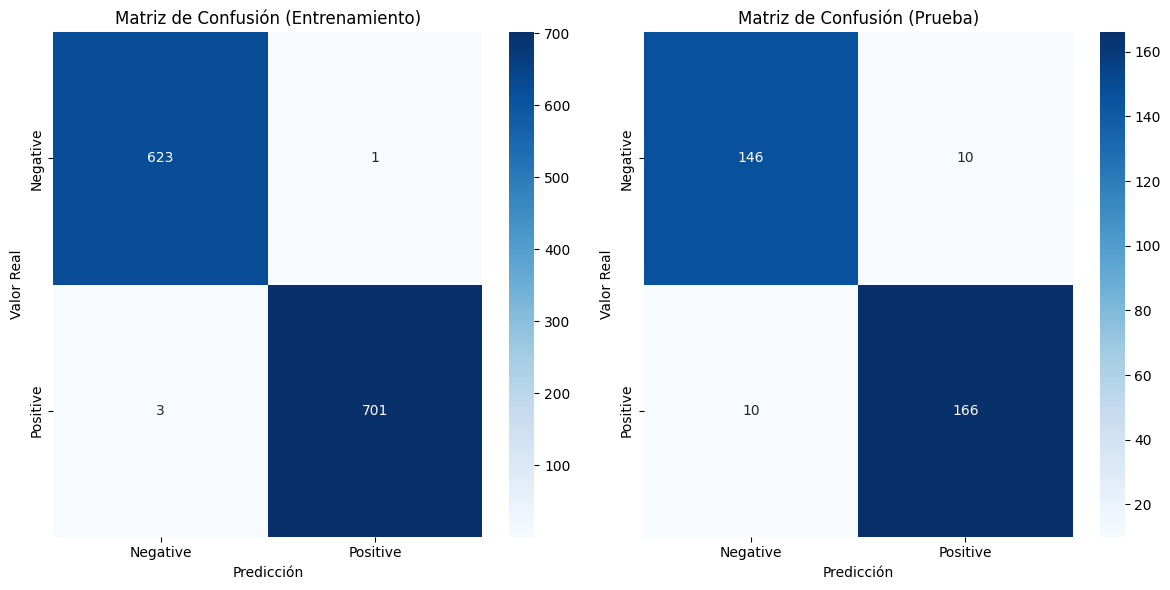

In [30]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


#  Evaluar el modelo en el conjunto de entrenamiento**
print("\nEvaluación en el Conjunto de Entrenamiento")
y_train_pred = svm_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy en Entrenamiento: {train_accuracy:.3f}")
print("Classification Report en Entrenamiento:\n", classification_report(y_train, y_train_pred))

#  Evaluar el modelo en el conjunto de prueba**
print("\nEvaluación en el Conjunto de Prueba")
y_test_pred = svm_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy en Prueba: {test_accuracy:.3f}")
print("Classification Report en Prueba:\n", classification_report(y_test, y_test_pred))

#  Comparativa de Accuracy**
print("\nComparativa de Accuracy:")
print(f"Entrenamiento: {train_accuracy:.3f} | Prueba: {test_accuracy:.3f}")

#  Visualización de Matrices de Confusión**
# Matriz de confusión para el conjunto de entrenamiento
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Matriz de Confusión (Entrenamiento)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')

# Matriz de confusión para el conjunto de prueba
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Matriz de Confusión (Prueba)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')

plt.tight_layout()
plt.show()

In [32]:
import joblib

#6. Guardar el modelo y el vectorizador
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']